**Import Required Libraries**

In [20]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import string
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

from time import time

import warnings
warnings.filterwarnings("ignore")

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Analysis of Data**



In [22]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Labs_MSc/US-Economic-News.csv', encoding = 'ISO-8859-1')
display(data.shape)

(8000, 15)

In [23]:
data["relevance"].value_counts()

no          6571
yes         1420
not sure       9
Name: relevance, dtype: int64

There is an imbalance in the data with not relevant being 82% in the dataset. That is, most of the articles are not relevant to US Economy, which makes sense in a real-world scenario, as news articles discuss various topics. We should keep this class imbalance mind when interpreting the classifier performance later. Let us first convert the class labels into binary outcome variables for convenience. 1 for Yes (relevant), and 0 for No (not relevant), and ignore "Not sure".

In [24]:
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,positivity,positivity:confidence,relevance,relevance:confidence,articleid,date,headline,positivity_gold,relevance_gold,text
0,842613455,False,finalized,3,12/5/15 17:48,3.0,0.6400,yes,0.640,wsj_398217788,8/14/91,Yields on CDs Fell in the Latest Week,NaN,NaN,NEW YORK -- Yields on most certificates of dep...
1,842613456,False,finalized,3,12/5/15 16:54,NaN,NaN,no,1.000,wsj_399019502,8/21/07,The Morning Brief: White House Seeks to Limit ...,NaN,NaN,The Wall Street Journal Online</br></br>The Mo...
2,842613457,False,finalized,3,12/5/15 1:59,NaN,NaN,no,1.000,wsj_398284048,11/14/91,Banking Bill Negotiators Set Compromise --- Pl...,NaN,NaN,WASHINGTON -- In an effort to achieve banking ...
3,842613458,False,finalized,3,12/5/15 2:19,NaN,0.0000,no,0.675,wsj_397959018,6/16/86,Manager's Journal: Sniffing Out Drug Abusers I...,NaN,NaN,The statistics on the enormous costs of employ...
4,842613459,False,finalized,3,12/5/15 17:48,3.0,0.3257,yes,0.640,wsj_398838054,10/4/02,Currency Trading: Dollar Remains in Tight Rang...,NaN,NaN,NEW YORK -- Indecision marked the dollar's ton...


In [25]:
data = data[data.relevance != "not sure"]
data.shape

(7991, 15)

In [26]:
data["relevance"].value_counts()/data.shape[0]

no     0.8223
yes    0.1777
Name: relevance, dtype: float64

In [27]:
fig = go.Figure([go.Bar(x=data['relevance'].value_counts().index, y=data['relevance'].value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

**Text Preprocessing**

In [28]:
data['relevance'] = data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0
data = data[["text","relevance"]] # taking text input and output variable as relevance
data = data[:1000]
data.shape

(1000, 2)

In [29]:
data.head()

,text,relevance
0,NEW YORK -- Yields on most certificates of dep...,1
1,The Wall Street Journal Online</br></br>The Mo...,0
2,WASHINGTON -- In an effort to achieve banking ...,0
3,The statistics on the enormous costs of employ...,0
4,NEW YORK -- Indecision marked the dollar's ton...,1


In [30]:
data['text'][0]

'NEW YORK -- Yields on most certificates of deposit offered by major banks dropped more than a tenth of a percentage point in the latest week, reflecting the overall decline in short-term interest rates.</br></br>On small-denomination, or "consumer," CDs sold directly by banks, the average yield on six-month deposits fell to 5.49% from 5.62% in the week ended yesterday, according to an 18-bank survey by Banxquote Money Markets, a Wilmington, Del., information service.</br></br>On three-month "consumer" deposits, the average yield sank to 5.29% from 5.42% the week before, according to Banxquote. Two banks in the Banxquote survey, Citibank in New York and CoreStates in Pennsylvania, are paying less than 5% on threemonth small-denomination CDs.</br></br>Declines were somewhat smaller on five-year consumer CDs, which eased to 7.37% from 7.45%, Banxquote said.</br></br>Yields on three-month and six-month Treasury bills sold at Monday\'s auction plummeted more than a fifth of a percentage po

# **Text Cleaning**

Typical steps involve tokenization, lower casing, removing, stop words, punctuation markers etc, and vectorization. Other processes such as stemming/lemmatization can also be performed. Here, we are performing the following steps: removing br tags, punctuation, numbers, and stopwords. While we are using sklearn's list of stopwords, there are several other stop word lists (e.g., from NLTK) or sometimes, custom stopword lists are needed depending on the task.

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [41]:
import nltk
# download the stopwords corpus
nltk.download('stopwords')
# import stopwords
from nltk.corpus import stopwords
# print the english stopwords
english_stopwords = set(stopwords.words('english'))
print(english_stopwords)
from nltk.corpus import stopwords

{'hers', 'did', 'and', 'needn', "that'll", 'as', 'while', 'there', 'with', 'where', 'should', 'can', 'do', 'then', 'just', 'or', "couldn't", 'further', "isn't", 'your', 'only', "didn't", 'him', 'that', "you'll", 'after', "weren't", 'whom', "you've", 'until', 'her', 'than', 'doing', 'again', 'more', 'have', 'themselves', 'nor', 'to', 'an', 'is', 'm', 'aren', 'me', 'why', 'so', 'his', 'about', 'will', "you'd", 'of', 'does', 'isn', 'you', "doesn't", "needn't", 'few', 'mightn', 'am', 'if', 'not', 'been', 'yours', 'don', 'yourself', 'mustn', 'under', 'but', 'up', 'same', 'doesn', 'being', 'hasn', 'myself', 'most', 'this', 'for', 'itself', "don't", 're', 'any', 'ma', 'y', 'who', 'these', 'over', 't', 'wouldn', "hadn't", 'was', 'weren', 'against', 'some', 'no', "hasn't", 'here', 'into', 'our', 'each', 'other', 'himself', 'theirs', 'has', 'own', 'from', 's', "she's", 'my', 'i', 'which', 'during', 'their', 'yourselves', 'shan', 'having', "aren't", "won't", 'had', "mustn't", 'haven', 'didn', "ha

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [48]:

#import spacy
#nlp = spacy.load('en_core_web_sm')
#stopwords = stop_words.ENGLISH_STOP_WORDS

import spacy
nlp = spacy.load('en_core_web_sm')

# Create a set of stop words
stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [49]:


lemmatizer = WordNetLemmatizer()

def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))

    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ")
    doc = doc.replace("-", " ")
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

In [50]:
clean(data['text'][0])

'new york yields certificates deposit offered major banks dropped tenth percentage point latest week reflecting overall decline short term interest rates br small denomination consumer cds sold directly banks average yield month deposits fell week ended yesterday according bank survey money markets information service br month consumer deposits average yield sank week according banks survey new york paying small denomination declines somewhat smaller year consumer cds eased said br yields month month bills sold s auction plummeted fifth percentage point previous week respectively'

In [51]:
data['text'] = data['text'].apply(clean)
data.head()

,text,relevance
0,new york yields certificates deposit offered m...,1
1,wall street journal online br morning brief lo...,0
2,effort achieve banking reform negotiators admi...,0
3,statistics enormous costs employee drug abuse ...,0
4,new york indecision marked dollar s tone trade...,1


**Steps in Modelling process using sklearn package**

*  Split the data into training and test sets (80% train, 20% test)
*   Extract features from the training data using TfidfVectorizer.
*   Transform the test data into the same feature vector as the training data.
*   Train the classifier
*   Evaluate the classifier













In [52]:
docs = list(data['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [53]:
X = docs
y = data['relevance']
print(X.shape, y.shape)

(1000, 12529) (1000,)


In [54]:
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each Sentiment",
    xaxis_title="Sentiment",
    yaxis_title="Values")
fig.show()

In [55]:
#Train-Test Split
SEED=123
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 12529) (800,)
(200, 12529) (200,)


# **Naive Bayes Classifier**

Gaussian Naive Bayes

In [56]:
gnb = GaussianNB()
%time gnb.fit(X_train, y_train)

y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 113 ms, sys: 87 ms, total: 200 ms
Wall time: 237 ms

Training Accuracy score: 0.9975
Testing Accuracy score: 0.765


In [57]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.77      0.99      0.86       151
    relevant       0.67      0.08      0.15        49

    accuracy                           0.77       200
   macro avg       0.72      0.53      0.50       200
weighted avg       0.74      0.77      0.69       200



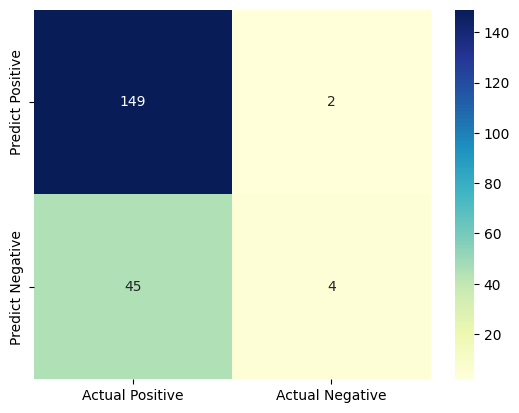

In [58]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

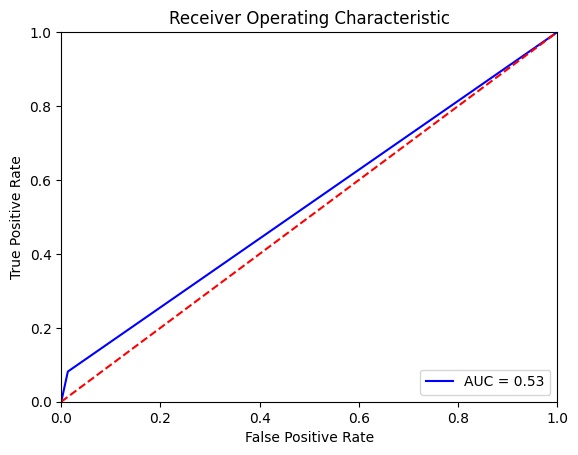

In [59]:
probs = gnb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Inference about Naive Bayes**

Gaussian Naive Bayes performs poorly in this case because of the prior and posterior probability condition

# **Multinomial Naive Bayes**


In [60]:
mnb = MultinomialNB()
%time mnb.fit(X_train, y_train)

y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 55.9 ms, sys: 3 ms, total: 58.8 ms
Wall time: 60.2 ms

Training Accuracy score: 0.7575
Testing Accuracy score: 0.755


In [61]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.76      1.00      0.86       151
    relevant       0.00      0.00      0.00        49

    accuracy                           0.76       200
   macro avg       0.38      0.50      0.43       200
weighted avg       0.57      0.76      0.65       200



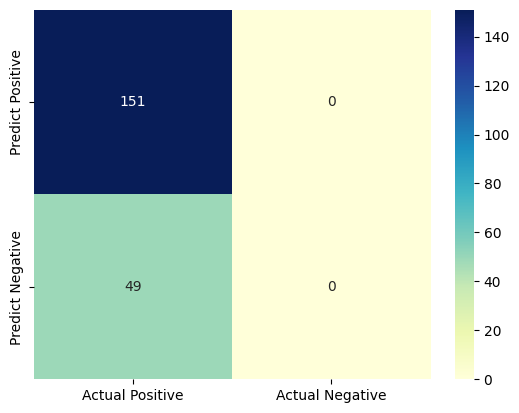

In [62]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

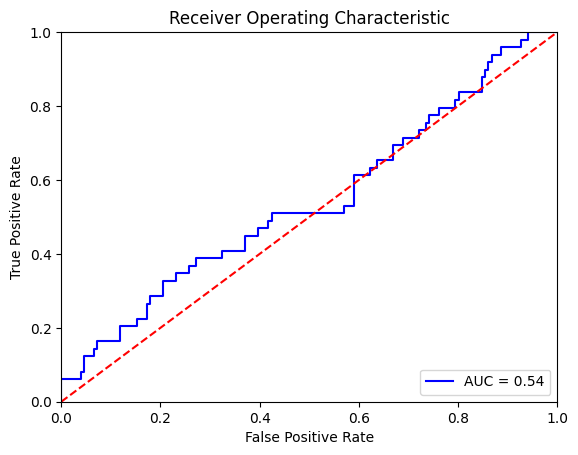

In [63]:
probs = mnb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Inference :**

Multinomial Naive Bayes performs slightly better than Gaussian Naive Bayes, but the low AUC score is because the size of feature vector is really big and Bayes Algorothm works better for small number of features.


# **Logistic Regression Classifier**

In [64]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 715 ms, sys: 180 ms, total: 894 ms
Wall time: 2.52 s

Training Accuracy score: 0.81125
Testing Accuracy score: 0.765


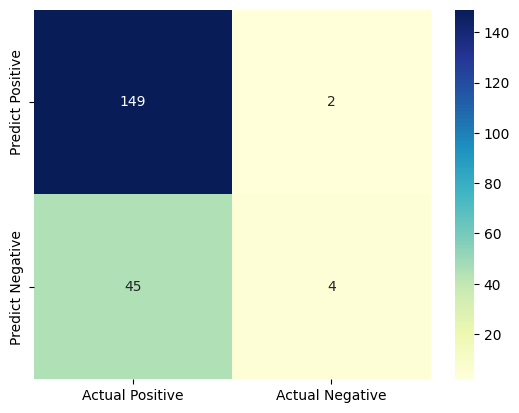

In [65]:
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [66]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.77      0.99      0.86       151
    relevant       0.67      0.08      0.15        49

    accuracy                           0.77       200
   macro avg       0.72      0.53      0.50       200
weighted avg       0.74      0.77      0.69       200



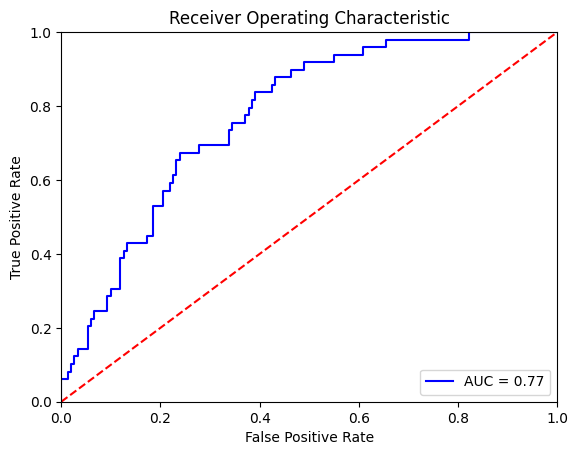

In [67]:
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Support Vector Machines**

In [68]:
svc =  LinearSVC(class_weight='balanced')
%time svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 84 ms, sys: 930 µs, total: 84.9 ms
Wall time: 95.3 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.75


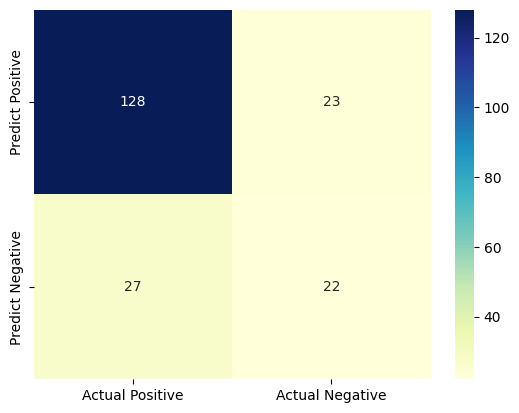

In [69]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [70]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.83      0.85      0.84       151
    relevant       0.49      0.45      0.47        49

    accuracy                           0.75       200
   macro avg       0.66      0.65      0.65       200
weighted avg       0.74      0.75      0.75       200



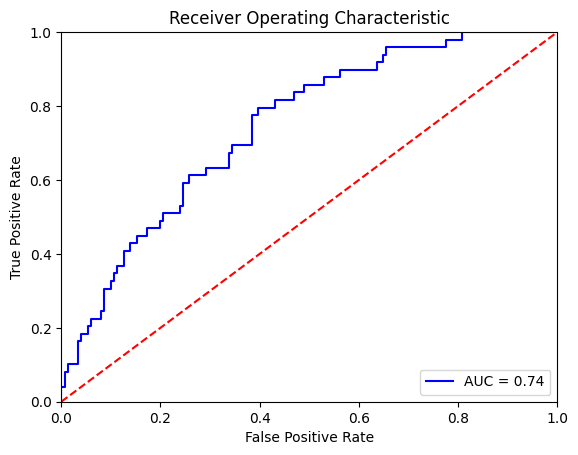

In [71]:
probs = svc._predict_proba_lr(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Decision Tree Classifier**

In [73]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

CPU times: user 2.97 s, sys: 26.7 ms, total: 3 s
Wall time: 3.08 s

Training Accuracy score: 1.0
Testing Accuracy score: 0.7


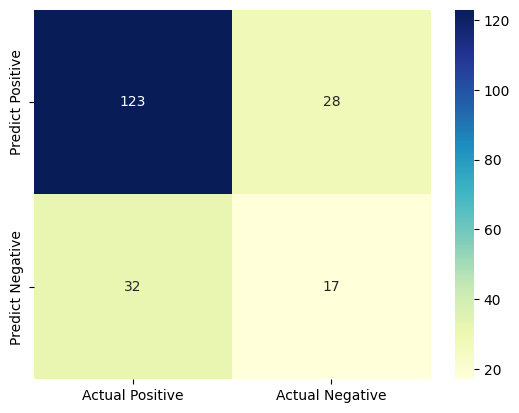

In [74]:
cm = confusion_matrix(y_test, y_pred_test)
# print('Confusion matrix\n', cm)

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
                        index=['Predict Positive', 'Predict Negative'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [75]:
print(classification_report(y_test, y_pred_test, target_names=['not relevant', 'relevant']))

              precision    recall  f1-score   support

not relevant       0.79      0.81      0.80       151
    relevant       0.38      0.35      0.36        49

    accuracy                           0.70       200
   macro avg       0.59      0.58      0.58       200
weighted avg       0.69      0.70      0.70       200



# **Ensembling**

In [76]:
from sklearn.ensemble import VotingClassifier

classifiers = [('Decision Tree', dt),
               ('Logistic Regression', lr),
                ('Naive Bayes', gnb)
              ]
vc = VotingClassifier(estimators=classifiers)
# Fit 'vc' to the traing set and predict test set labels
vc.fit(X_train, y_train)
y_pred_train=vc.predict(X_train)
y_pred_test = vc.predict(X_test)
print("Training Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))

Training Accuracy score: 1.0
Testing Accuracy score: 0.77


In [77]:
predictions = pd.Series(vc.predict(X), name="relevant")
results = pd.concat([predictions],axis=1)
results.to_csv("us-economic-news-relevance.csv",index=False)

 how do we choose whats the best? If we look at overall accuracy alone, we should be choosing the very first classifier in this notebook. However, that is also doing poorly with identifying "relevant" articles. If we choose purely based on how good it is doing with "relevant" category, we should choose the second one we built. If we choose purely based on how good it is doing with "irrelevant" category, surely, nothing beats not building any classifier and just calling everything irrelevant! So, what to choose as the best among these depends on what we are looking for in our usecase!

[link ](https://www.kaggle.com/code/heeraldedhia/text-classification-nlp)